In [1]:
import pydotplus
import pandas as pd
import numpy as np
from io import StringIO
# from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from classes import BalancedUndersamplingShuffle, balanced_sampling
from helpers import plot_learning_curve, plot_validation_curve
from sklearn.metrics import check_scoring
from sklearn.model_selection._validation import _fit_and_score
from sklearn.model_selection import ShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import fbeta_score, make_scorer

In [2]:
from scipy.io import arff

with open('1year.arff','r') as f:
    data1, meta1 = arff.loadarff(f)
    data1 = np.asarray(data1.tolist(), dtype=np.float32)
    print(data1.shape)

with open('2year.arff','r') as f:
    data2, meta2 = arff.loadarff(f)
    data2 = np.asarray(data2.tolist(), dtype=np.float32)
    print(data2.shape)

with open('3year.arff','r') as f:
    data3, meta3 = arff.loadarff(f)
    data3 = np.asarray(data3.tolist(), dtype=np.float32)
    print(data3.shape)

with open('4year.arff','r') as f:
    data4, meta4 = arff.loadarff(f)
    data4 = np.asarray(data4.tolist(), dtype=np.float32)
    print(data4.shape)

with open('5year.arff','r') as f:
    data5, meta5 = arff.loadarff(f)
    data5 = np.asarray(data5.tolist(), dtype=np.float32)
    print(data5.shape)


(7027, 65)
(10173, 65)
(10503, 65)
(9792, 65)
(5910, 65)


In [3]:
data = np.concatenate([data1, data2, data3, data4, data5], axis=0)
data[np.isnan(data)] = 0


# 
# drop_columns = [23, ]
# convert_nan_to_0_cols = [4, 26, 36, 44, 59]

# replace column i = 36 nans with 0's
# for i in convert_nan_to_0_cols:
#     col = data[:, i]
#     col[np.isnan(col)] = 0
#     print(f'col36 nans={np.count_nonzero(np.isnan(data[:,36]))}')


# data = np.delete(data, drop_columns, axis=1)
# print(np.count_nonzero(np.isnan(data), axis=0))
# print(data.shape)

# print(f'dropped = {dropped.shape}')
# print(np.isnan(data).any(axis=1))
# nans = data[np.isnan(data).any(axis=1)]
# data = data[~np.isnan(data).any(axis=1)]

# print(f'label=1 shape after dropping = {data[data[:,-1]==1].shape}')
# _data = np.copy(data)
# _data[:, 0] = _data[:, 1]
# print(f'0= {_data[:, 0]}')
# print(f'1= {_data[:, 1]}')
# print(f'_data={_data}')

# print(f'data.shape={data.shape}')

X, y = data[:,:-1], data[:, -1]

X, y, idx = balanced_sampling(X, y, r = 3, random_state=42)

print(f'X.shape={X.shape}, y.shape={y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


a=0.10662111516202229, r=3, gamma=19.758010521281683
X.shape=(8362, 64), y.shape=(8362,)


In [11]:
# Naive fit
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
classifier = DecisionTreeClassifier(random_state=0, criterion='gini')
train, test = list(cv.split(X, y))[0]
scorer = check_scoring(classifier, scoring='f1')
estimator_params = dict(random_state=0)
verbose = 0

In [12]:
results = _fit_and_score(classifier, X, y, scorer, train, test, verbose,
                         parameters=estimator_params, fit_params=None,
                         return_train_score=True, return_n_test_samples=True,
                         return_times=True, return_parameters=True,
                         error_score='raise')
results

{'fit_failed': False,
 'test_scores': 0.6889952153110048,
 'train_scores': 1.0,
 'n_test_samples': 837,
 'fit_time': 0.5075216293334961,
 'score_time': 0.002435445785522461,
 'parameters': {'random_state': 0}}

## Hyperparameter tuning

### max_depth

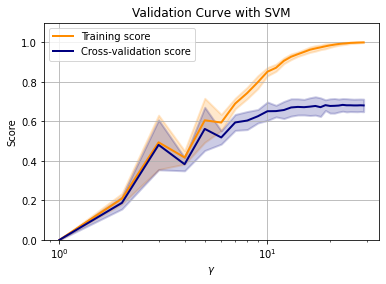

In [22]:
param_range = range(1, 30)
classifier = DecisionTreeClassifier(random_state=0, criterion='gini')
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
train_scores, test_scores = plot_validation_curve(classifier, X_train, y_train, 
                      param_name='max_depth', param_range=param_range,
                      cv=cv, scoring='recall', n_jobs=8)


In [15]:
test_scores_mean = np.mean(test_scores, axis=1)
optimal_max_depth = param_range[np.argmax(test_scores_mean)]
print(f'optimal_max_depth={optimal_max_depth}, accuracy={test_scores_mean[optimal_max_depth]}')

optimal_max_depth=13, accuracy=0.6805533156144236


In [16]:
#Validate on test set
classifier = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=13)
scorer = check_scoring(classifier, scoring='f1')
classifier.fit(X_train, y_train)
scorer(classifier, X_test, y_test)
# print(type(scorer))

0.6880131362889984

### criterion

In [17]:
# criterion = 'entropy'
classifier = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=13)
scorer = check_scoring(classifier, scoring='f1')
classifier.fit(X_train, y_train)
score = scorer(classifier, X_test, y_test)
print(f'entropy score = {score}')


# criterion = 'gini'
classifier = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=13)
scorer = check_scoring(classifier, scoring='f1')
classifier.fit(X_train, y_train)
score = scorer(classifier, X_test, y_test)
print(f'gini score = {score}')


entropy score = 0.700162074554295
gini score = 0.6880131362889984


### min_samples_split

optimal min_samples_split=3, f1=0.6813523878554217


0.700162074554295

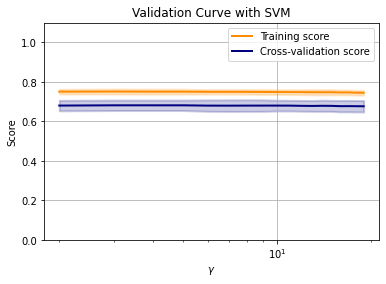

In [18]:
param_range = range(2, 20)
classifier = DecisionTreeClassifier(random_state=0, max_depth=7, criterion='entropy')
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

train_scores, test_scores = plot_validation_curve(classifier, X, y, 
                  param_name='min_samples_split', param_range=param_range,
                  cv=cv, scoring='f1', n_jobs=8)

test_scores_mean = np.mean(test_scores, axis=1)
optimal_min_samples_split = param_range[np.argmax(test_scores_mean)]
print(f'optimal min_samples_split={optimal_min_samples_split}, f1={test_scores_mean[optimal_min_samples_split]}')

#Validate on test set
classifier = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=optimal_max_depth)
scorer = check_scoring(classifier, scoring='f1')
classifier.fit(X_train, y_train)
scorer(classifier, X_test, y_test)


### min_samples_leaf

optimal min_samples_leaf=21, f1=0.8566171048344223


0.6826051112943116

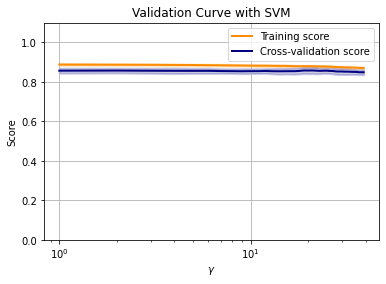

In [19]:
param_range = range(1, 40)
classifier = DecisionTreeClassifier(random_state=0, max_depth=7, criterion='entropy')
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

train_scores, test_scores = plot_validation_curve(classifier, X, y, 
                      param_name='min_samples_leaf', param_range=param_range,
                      cv=cv, scoring='accuracy', n_jobs=8)


test_scores_mean = np.mean(test_scores, axis=1)
optimal_min_samples_leaf = param_range[np.argmax(test_scores_mean)]
print(f'optimal min_samples_leaf={optimal_min_samples_leaf}, f1={test_scores_mean[optimal_min_samples_leaf]}')

#Validate on test set
classifier = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=optimal_max_depth, 
                                   min_samples_split = optimal_min_samples_split,
                                   min_samples_leaf = optimal_min_samples_leaf)
scorer = check_scoring(classifier, scoring='f1')
classifier.fit(X_train, y_train)
scorer(classifier, X_test, y_test)

# Learning curves

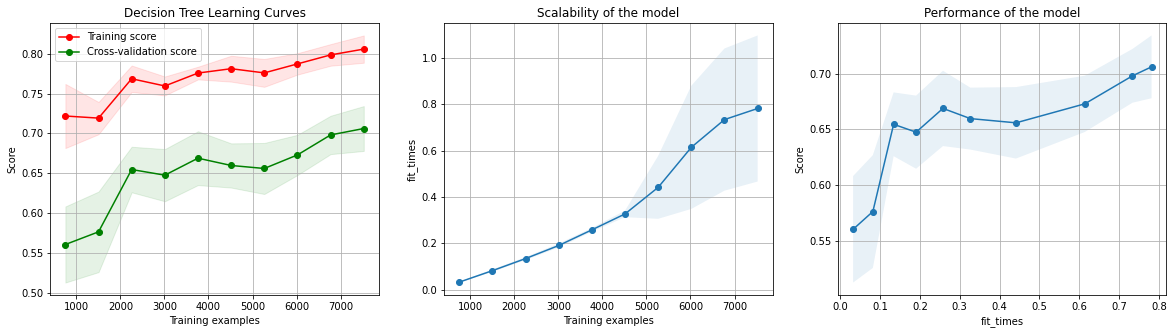

In [21]:
classifier = DecisionTreeClassifier(random_state=0, criterion='entropy', 
                                    max_depth=optimal_max_depth,
                                    min_samples_split=optimal_min_samples_split, 
                                    min_samples_leaf=optimal_min_samples_leaf)
title = 'Decision Tree Learning Curves'
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
plt = plot_learning_curve(classifier, title, X, y, axes=None, ylim=None, cv=cv,
                            n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10), scoring='f1')

In [ ]:
dot_data = StringIO()
classifier = DecisionTreeClassifier(random_state=0, max_depth=7, criterion='gini')
export_graphviz(
    classifier,
    out_file=dot_data,
    feature_names=meta1.names()[:-1],
    class_names=['0', '1'],
    rounded=True,
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('poland.png')
